# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera



## Introduction: Business Problem <a name="introduction"></a>

In current times it is not a good choice investing money in saving accounts because of the very low interest rate. Thus, I want to invest a portion of my savings into a commercial business to generate higher income.


### Objective

Because my passion is Wine tasting, and I really would like to live in New York, the goal is to find the most suitable neighborhood in New York to open a successful Wine Bar.

### Criteria

* The Wine Bar will be in a central part of the city to attract more people -> Around Manhattan.
* The Wine Bar will be nearby other restaurants. It will be perfect for a glass of wine after work and before dinner.
* The Wine Bar will be located in a neighborhood with other similar wine bars. If they are operating it probably means that it is the right area to open a new one.

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [123]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
import wget

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

## Data

Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

Luckily, this dataset exists for free on the web, here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572

In [31]:
wget.download('https://cocl.us/new_york_dataset/newyork_data.json')
print('Data downloaded!')

100% [............................................................................] 115774 / 115774Data downloaded!


Load the Data from The json file of New York can be downloaded from:   https://cocl.us/new_york_dataset/newyork_data.json

In [140]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.

In [33]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe. So let's start by creating an empty dataframe.

In [34]:
neighborhoods_data = newyork_data['features']

In [35]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [36]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [37]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [38]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


### Use geopy library

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [39]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [40]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

However, since we decided to open the Wine Bar in the central part of the city, we simplify the above map and segment and cluster only the neighborhoods in Manhattan. So let's slice the original dataframe and create a new dataframe of the Manhattan data.

In [41]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Let's get the geographical coordinates of Manhattan.

In [42]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


As we did with all of New York City, let's visualizat Manhattan the neighborhoods in it.

In [43]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

### Foursquare

In [44]:
CLIENT_ID = 'JJ35VB3QXEUAORRP5ZWZM13RDMLFB5SUBZVDXOBRSUQILLCT' # your Foursquare ID
CLIENT_SECRET = 'HJBDDJPBAO03YHPOUFS0T5NHMHOFEUUOY5IFXDJPJ3AV2SUA' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JJ35VB3QXEUAORRP5ZWZM13RDMLFB5SUBZVDXOBRSUQILLCT
CLIENT_SECRET:HJBDDJPBAO03YHPOUFS0T5NHMHOFEUUOY5IFXDJPJ3AV2SUA


Get the neighborhood's name.

In [45]:
manhattan_data.loc[0, 'Neighborhood']

'Marble Hill'

Get the neighborhood's latitude and longitude values.

In [46]:
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Marble Hill are 40.87655077879964, -73.91065965862981.


Now, let's get the top 100 venues that are in Marble Hill within a radius of 500 meters.

First, let's create the GET request URL. Name your URL **url**.

In [47]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL


'https://api.foursquare.com/v2/venues/explore?&client_id=JJ35VB3QXEUAORRP5ZWZM13RDMLFB5SUBZVDXOBRSUQILLCT&client_secret=HJBDDJPBAO03YHPOUFS0T5NHMHOFEUUOY5IFXDJPJ3AV2SUA&v=20180605&ll=40.87655077879964,-73.91065965862981&radius=500&limit=100'

Double-click __here__ for the solution.
<!-- The correct answer is:
LIMIT = 100 # limit of number of venues returned by Foursquare API
-->

<!--
radius = 500 # define radius
-->

<!--
\\ # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL
--> 

Send the GET request and examine the resutls

In [48]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e958befdf2774001b686ca5'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Marble Hill',
  'headerFullLocation': 'Marble Hill, New York',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 25,
  'suggestedBounds': {'ne': {'lat': 40.88105078329964,
    'lng': -73.90471933917806},
   'sw': {'lat': 40.87205077429964, 'lng': -73.91659997808156}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b4429abf964a52037f225e3',
       'name': "Arturo's",
       'location': {'address': '5198 Broadway',
        'crossStreet': 'at 225th St.',
        'lat': 40.87441177110231,
        'lng': -73.91027100981574,
        'labeledLatLngs': [{'label'

From the Foursquare lab in the previous module, we know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [49]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [50]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Arturo's,Pizza Place,40.874412,-73.910271
1,Bikram Yoga,Yoga Studio,40.876844,-73.906204
2,Tibbett Diner,Diner,40.880404,-73.908937
3,Dunkin',Donut Shop,40.877136,-73.906666
4,Starbucks,Coffee Shop,40.877531,-73.905582


And how many venues were returned by Foursquare?

In [51]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

25 venues were returned by Foursquare.


## Methodology

* We find the neighborhoods of Manhattan
* We find all the venues in each neighborhoods
* We cluster the neighborhoods
* We define the best neighboroods/cluster to open the Wine Bar based on the number of similar bars open in the area

## Analysis

Let's create a function to explore all the neighborhoods in Manhattan

In [52]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now write the code to run the above function on each neighborhood and create a new dataframe called *manhattan_venues*.

In [55]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )



Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


Let's check the size of the resulting dataframe

In [56]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3161, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


Let's check how many venues were returned for each neighborhood

In [57]:
manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,70,70,70,70,70,70
Carnegie Hill,88,88,88,88,88,88
Central Harlem,45,45,45,45,45,45
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,39,39,39,39,39,39
East Village,100,100,100,100,100,100


Let's find out how many unique categories can be curated from all the returned venues

In [58]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 323 uniques categories.


Analyze Each Neighborhood

In [59]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,South American Restaur

And let's examine the new dataframe size.

In [60]:
manhattan_onehot.shape

(3161, 324)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [61]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,South American Restaur

Let's drop the columns which are not related to other restaurants or wine bars

In [62]:
l = manhattan_grouped.columns
l

Index(['Neighborhood', 'Accessories Store', 'Adult Boutique',
       'Afghan Restaurant', 'African Restaurant', 'American Restaurant',
       'Antique Shop', 'Arcade', 'Arepa Restaurant', 'Argentinian Restaurant',
       ...
       'Video Store', 'Vietnamese Restaurant', 'Volleyball Court',
       'Waterfront', 'Whisky Bar', 'Wine Bar', 'Wine Shop', 'Wings Joint',
       'Women's Store', 'Yoga Studio'],
      dtype='object', length=324)

First let's use the keyword 'Restaurant'

In [63]:
# initializing substring 
subs1 = 'Restaurant'
  
# using list comprehension  
# to get string with substring  
res1 = [i for i in manhattan_grouped.columns if subs1 in i] 
res1

['Afghan Restaurant',
 'African Restaurant',
 'American Restaurant',
 'Arepa Restaurant',
 'Argentinian Restaurant',
 'Asian Restaurant',
 'Australian Restaurant',
 'Austrian Restaurant',
 'Brazilian Restaurant',
 'Cajun / Creole Restaurant',
 'Cambodian Restaurant',
 'Cantonese Restaurant',
 'Caribbean Restaurant',
 'Caucasian Restaurant',
 'Chinese Restaurant',
 'Cuban Restaurant',
 'Czech Restaurant',
 'Dim Sum Restaurant',
 'Dumpling Restaurant',
 'Eastern European Restaurant',
 'Empanada Restaurant',
 'English Restaurant',
 'Ethiopian Restaurant',
 'Falafel Restaurant',
 'Fast Food Restaurant',
 'Filipino Restaurant',
 'French Restaurant',
 'German Restaurant',
 'Greek Restaurant',
 'Hawaiian Restaurant',
 'Himalayan Restaurant',
 'Hotpot Restaurant',
 'Indian Restaurant',
 'Israeli Restaurant',
 'Italian Restaurant',
 'Japanese Curry Restaurant',
 'Japanese Restaurant',
 'Jewish Restaurant',
 'Korean Restaurant',
 'Kosher Restaurant',
 'Latin American Restaurant',
 'Lebanese Rest

First let's use the keyword 'Bar'

In [64]:
# initializing substring 
subs2 = 'Bar'
  
# using list comprehension  
# to get string with substring  
res2 = [i for i in manhattan_grouped.columns if subs2 in i] 
res2

['Bar',
 'Beer Bar',
 'Cocktail Bar',
 'Dive Bar',
 'Gay Bar',
 'Hookah Bar',
 'Hotel Bar',
 'Juice Bar',
 'Karaoke Bar',
 'Sake Bar',
 'Salon / Barbershop',
 'Sports Bar',
 'Tiki Bar',
 'Whisky Bar',
 'Wine Bar']

In [65]:
# Let;s consider that only Beer Bar, Wine Bar and Whisky Bar are relevant for our business
res2 = ['Neighborhood','Beer Bar', 'Wine Bar', 'Whisky Bar']

In [66]:
res12=res2+res1
res12

['Neighborhood',
 'Beer Bar',
 'Wine Bar',
 'Whisky Bar',
 'Afghan Restaurant',
 'African Restaurant',
 'American Restaurant',
 'Arepa Restaurant',
 'Argentinian Restaurant',
 'Asian Restaurant',
 'Australian Restaurant',
 'Austrian Restaurant',
 'Brazilian Restaurant',
 'Cajun / Creole Restaurant',
 'Cambodian Restaurant',
 'Cantonese Restaurant',
 'Caribbean Restaurant',
 'Caucasian Restaurant',
 'Chinese Restaurant',
 'Cuban Restaurant',
 'Czech Restaurant',
 'Dim Sum Restaurant',
 'Dumpling Restaurant',
 'Eastern European Restaurant',
 'Empanada Restaurant',
 'English Restaurant',
 'Ethiopian Restaurant',
 'Falafel Restaurant',
 'Fast Food Restaurant',
 'Filipino Restaurant',
 'French Restaurant',
 'German Restaurant',
 'Greek Restaurant',
 'Hawaiian Restaurant',
 'Himalayan Restaurant',
 'Hotpot Restaurant',
 'Indian Restaurant',
 'Israeli Restaurant',
 'Italian Restaurant',
 'Japanese Curry Restaurant',
 'Japanese Restaurant',
 'Jewish Restaurant',
 'Korean Restaurant',
 'Kosher 

In [67]:
col_to_drop = list(set(manhattan_grouped.columns) - set(res12))
col_to_drop

['Skate Park',
 'Dance Studio',
 'Tea Room',
 'College Academic Building',
 'Juice Bar',
 'Heliport',
 'Bike Rental / Bike Share',
 'Salon / Barbershop',
 'Laundry Service',
 'Theater',
 'Bridal Shop',
 'Breakfast Spot',
 'Health & Beauty Service',
 'Candy Store',
 'Gastropub',
 'Soup Place',
 'Fried Chicken Joint',
 'Pilates Studio',
 'Bookstore',
 'Event Space',
 'Tennis Court',
 "Men's Store",
 'Electronics Store',
 'Opera House',
 'Bike Shop',
 'Cocktail Bar',
 'Waterfront',
 'Jazz Club',
 'BBQ Joint',
 'Wings Joint',
 'Tourist Information Center',
 'Boxing Gym',
 'Drugstore',
 'Soccer Field',
 'Pub',
 'Gift Shop',
 'Hookah Bar',
 'Bakery',
 'Liquor Store',
 'Trail',
 'Cosmetics Shop',
 'Nail Salon',
 'Department Store',
 'Outdoor Sculpture',
 'Gay Bar',
 'Butcher',
 'Music Venue',
 'Market',
 'Baby Store',
 'Food Truck',
 'Mini Golf',
 'Camera Store',
 'Wine Shop',
 'College Arts Building',
 'Pharmacy',
 'Burger Joint',
 'Boat or Ferry',
 'Theme Park Ride / Attraction',
 'Pet Café

In [68]:
manhattan_grouped.shape

(40, 324)

In [69]:
manhattan_grouped.drop(columns=col_to_drop, inplace=True)
manhattan_grouped.shape

(40, 78)

In [70]:
manhattan_grouped.head()


,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Beer Bar,Brazilian Restaurant,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Persian Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar
0,Battery Park City,0.0,0.000000,0.014286,0.0,0.0,0.00,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.014286,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.000000,0.00,0.028571,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.028571,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.00,0.000000,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
1,Carnegie Hill,0.0,0.000000,0.011364,0.0,0.0,0.00,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.000000,0.0,0.011364,0.0,0.022727,0.0,0.00,0.0,0.0,0.00,0.011364,0.00,0.034091,0.0,0.034091,0.0,0.0,0.011364,0.0,0.0,0.00,0.00,0.011364,0.00,0.0,0.0,0.0,0.011364,0.0,0.0,0.0,0.011364,0.011364,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.00,0.011364,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.0,0.011364,0.011364,0.0,0.011364
2,Central Harlem,0.0,0.044444,0.044444,0.0,0.0,0.00,0.0,0.00,0.022222,0.0,0.0,0.0,0.00,0.022222,0.0,0.044444,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.022222,0.0,0.000000,0.0,0.044444,0.0,0.00,0.0,0.0,0.00,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.000000,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.044444,0.00,0.0,0.0,0.022222,0.00,0.000000,0.0,0.0,0.00,0.022222,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
3,Chelsea,0.0,0.000000,0.040000,0.0,0.0,0.01,0.0,0.00,0.010000,0.0,0.0,0.0,0.00,0.000000,0.0,0.010000,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.000000,0.01,0.030000,0.0,0.010000,0.0,0.0,0.000000,0.0,0.0,0.00,0.01,0.010000,0.01,0.0,0.0,0.0,0.010000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.020000,0.00,0.0,0.0,0.000000,0.01,0.010000,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.010000
4,Chinatown,0.0,0.000000,0.040000,0.0,0.0,0.02,0.0,0.01,0.000000,0.0,0.0,0.0,0.01,0.000000,0.0,0.090000,0.0,0.0,0.02,0.02,0.0,0.0,0.01,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.02,0.0,0.0,0.03,0.000000,0.00,0.010000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.02,0.00,0.020000,0.00,0.0,0.0,0.0,0.010000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.02,0.0,0.0,0.000000,0.01,0.000000,0.0,0.0,0.01,0.000000,0.01,0.0,0.0,0.0,0.010000,0.030000,0.0,0.000000


Let's cnisder that only the total number of restaurants is relevant for our analysis

In [71]:
# create a dataframe with only restaurants

#df_restaurants = manhattan_grouped[res1]
#df_restaurants.head()

In [72]:
#manhattan_grouped.drop(columns=res1, inplace=True)
#manhattan_grouped.head()

In [73]:
# sum all the restaurants in to anew column 'Restaurants'

#df_restaurants['Restaurants']=df_restaurants.iloc[:,:].sum(axis=1)
#df_restaurants.head()


In [74]:
# add the columns Restaurants in the manhattan_grouped df

#manhattan_grouped['Restaurants'] = df_restaurants['Restaurants']
#manhattan_grouped.head()

Let's print each neighborhood along with the top 5 most common venues

In [75]:
#### Let's print each neighborhood along with the top 5 most common venues

In [76]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
                 venue  freq
0   Italian Restaurant  0.03
1   Mexican Restaurant  0.03
2  American Restaurant  0.01
3   Chinese Restaurant  0.01
4    Afghan Restaurant  0.00


----Carnegie Hill----
                  venue  freq
0    Italian Restaurant  0.03
1   Japanese Restaurant  0.03
2     French Restaurant  0.02
3              Wine Bar  0.01
4  Fast Food Restaurant  0.01


----Central Harlem----
                 venue  freq
0   Seafood Restaurant  0.04
1   Chinese Restaurant  0.04
2  American Restaurant  0.04
3   African Restaurant  0.04
4    French Restaurant  0.04


----Chelsea----
                 venue  freq
0  American Restaurant  0.04
1   Italian Restaurant  0.03
2   Seafood Restaurant  0.02
3   Spanish Restaurant  0.01
4     Sushi Restaurant  0.01


----Chinatown----
                   venue  freq
0     Chinese Restaurant  0.09
1    American Restaurant  0.04
2  Vietnamese Restaurant  0.03
3      Hotpot Restaurant  0.03
4       Malay Restaurant  0.02

put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [77]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [78]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Battery Park City,Italian Restaurant,Mexican Restaurant,American Restaurant,Chinese Restaurant,Wine Bar
1,Carnegie Hill,Italian Restaurant,Japanese Restaurant,French Restaurant,Wine Bar,Sushi Restaurant
2,Central Harlem,African Restaurant,American Restaurant,Chinese Restaurant,Seafood Restaurant,French Restaurant
3,Chelsea,American Restaurant,Italian Restaurant,Seafood Restaurant,Wine Bar,Sushi Restaurant
4,Chinatown,Chinese Restaurant,American Restaurant,Hotpot Restaurant,Vietnamese Restaurant,Asian Restaurant


<a id='item4'></a>

### Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [79]:
# Let's define 5 different clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', axis=1) # it works only with numbers
manhattan_grouped_clustering.head()



,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Beer Bar,Brazilian Restaurant,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Persian Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar
0,0.0,0.000000,0.014286,0.0,0.0,0.00,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.014286,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.000000,0.00,0.028571,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.028571,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.00,0.000000,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
1,0.0,0.000000,0.011364,0.0,0.0,0.00,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.000000,0.0,0.011364,0.0,0.022727,0.0,0.00,0.0,0.0,0.00,0.011364,0.00,0.034091,0.0,0.034091,0.0,0.0,0.011364,0.0,0.0,0.00,0.00,0.011364,0.00,0.0,0.0,0.0,0.011364,0.0,0.0,0.0,0.011364,0.011364,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.00,0.011364,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.0,0.011364,0.011364,0.0,0.011364
2,0.0,0.044444,0.044444,0.0,0.0,0.00,0.0,0.00,0.022222,0.0,0.0,0.0,0.00,0.022222,0.0,0.044444,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.022222,0.0,0.000000,0.0,0.044444,0.0,0.00,0.0,0.0,0.00,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.000000,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.044444,0.00,0.0,0.0,0.022222,0.00,0.000000,0.0,0.0,0.00,0.022222,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
3,0.0,0.000000,0.040000,0.0,0.0,0.01,0.0,0.00,0.010000,0.0,0.0,0.0,0.00,0.000000,0.0,0.010000,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.000000,0.01,0.030000,0.0,0.010000,0.0,0.0,0.000000,0.0,0.0,0.00,0.01,0.010000,0.01,0.0,0.0,0.0,0.010000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.020000,0.00,0.0,0.0,0.000000,0.01,0.010000,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.010000
4,0.0,0.000000,0.040000,0.0,0.0,0.02,0.0,0.01,0.000000,0.0,0.0,0.0,0.01,0.000000,0.0,0.090000,0.0,0.0,0.02,0.02,0.0,0.0,0.01,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.02,0.0,0.0,0.03,0.000000,0.00,0.010000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.02,0.00,0.020000,0.00,0.0,0.0,0.0,0.010000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.02,0.0,0.0,0.000000,0.01,0.000000,0.0,0.0,0.01,0.000000,0.01,0.0,0.0,0.0,0.010000,0.030000,0.0,0.000000


In [80]:
# Normalize the values in the manhattan_grouped df

from sklearn import preprocessing

x = manhattan_grouped_clustering.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
manhattan_grouped_clustering = pd.DataFrame(x_scaled)
manhattan_grouped_clustering.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76
0,0.0,0.0,0.180952,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.158730,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,0.285714,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.185714,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
1,0.0,0.0,0.143939,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.659091,0.0,0.454545,0.0,0.000000,0.0,0.0,0.0,0.200758,0.00,0.340909,0.0,0.681818,0.0,0.0,0.318182,0.0,0.0,0.0,0.000000,0.073864,0.00,0.0,0.0,0.0,0.189394,0.0,0.0,0.0,0.289773,0.219697,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000,0.227273,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.378788,0.378788,0.0,0.227273
2,0.0,1.0,0.562963,0.0,0.0,0.00,0.0,0.0,0.866667,0.0,0.0,0.0,0.0,0.644444,0.0,0.493827,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.844444,0.0,0.000000,0.0,0.888889,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.681481,0.0,0.0,0.0,1.0,0.000,0.000000,0.0,0.0,0.0,0.955556,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
3,0.0,0.0,0.506667,0.0,0.0,0.38,0.0,0.0,0.390000,0.0,0.0,0.0,0.0,0.000000,0.0,0.111111,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.78,0.300000,0.0,0.200000,0.0,0.0,0.000000,0.0,0.0,0.0,0.333333,0.065000,0.39,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.306667,0.0,0.0,0.0,0.0,0.325,0.200000,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.200000
4,0.0,0.0,0.506667,0.0,0.0,0.76,0.0,1.0,0.000000,0.0,0.0,0.0,1.0,0.000000,0.0,1.000000,0.0,0.0,1.0,0.92,0.0,0.0,1.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.506667,0.0,0.0,1.0,0.000000,0.00,0.100000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,0.000000,0.130000,0.00,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.325,0.000000,0.0,0.0,1.0,0.000000,0.13,0.0,0.0,0.0,0.333333,1.000000,0.0,0.000000


In [81]:
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 3, 3, 4, 1, 3, 3, 3, 3])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [82]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,3,Seafood Restaurant,American Restaurant,Wine Bar,French Restaurant,Empanada Restaurant
1,Manhattan,Chinatown,40.715618,-73.994279,4,Chinese Restaurant,American Restaurant,Hotpot Restaurant,Vietnamese Restaurant,Asian Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,3,Chinese Restaurant,Spanish Restaurant,Latin American Restaurant,Mexican Restaurant,New American Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,3,Mexican Restaurant,Restaurant,Chinese Restaurant,Wine Bar,American Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,3,Mexican Restaurant,Sushi Restaurant,Indian Restaurant,Chinese Restaurant,Caribbean Restaurant


Finally, let's visualize the resulting clusters

In [83]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## Results and discussions

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories.

Cluster 1

In [84]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
15,Midtown,Japanese Restaurant,French Restaurant,Mediterranean Restaurant,Cuban Restaurant,Chinese Restaurant
16,Murray Hill,Japanese Restaurant,Sushi Restaurant,American Restaurant,Jewish Restaurant,Vietnamese Restaurant


Cluster 2

In [85]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
8,Upper East Side,Italian Restaurant,French Restaurant,Sushi Restaurant,Japanese Restaurant,Mexican Restaurant
9,Yorkville,Italian Restaurant,Sushi Restaurant,Japanese Restaurant,Mexican Restaurant,Vietnamese Restaurant
10,Lenox Hill,Italian Restaurant,Sushi Restaurant,Turkish Restaurant,Thai Restaurant,Wine Bar
12,Upper West Side,Italian Restaurant,American Restaurant,Middle Eastern Restaurant,Sushi Restaurant,Seafood Restaurant
18,Greenwich Village,Italian Restaurant,Sushi Restaurant,French Restaurant,American Restaurant,Chinese Restaurant
31,Noho,Italian Restaurant,Japanese Restaurant,French Restaurant,Wine Bar,American Restaurant
32,Civic Center,French Restaurant,Sushi Restaurant,American Restaurant,Italian Restaurant,Falafel Restaurant
34,Sutton Place,Italian Restaurant,Beer Bar,Indian Restaurant,Vegetarian / Vegan Restaurant,American Restaurant
35,Turtle Bay,Italian Restaurant,Japanese Restaurant,French Restaurant,Sushi Restaurant,Wine Bar


Cluster 3

In [86]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
25,Manhattan Valley,Indian Restaurant,Mexican Restaurant,Thai Restaurant,Chinese Restaurant,Vietnamese Restaurant


Cluster 4

In [87]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Marble Hill,Seafood Restaurant,American Restaurant,Wine Bar,French Restaurant,Empanada Restaurant
2,Washington Heights,Chinese Restaurant,Spanish Restaurant,Latin American Restaurant,Mexican Restaurant,New American Restaurant
3,Inwood,Mexican Restaurant,Restaurant,Chinese Restaurant,Wine Bar,American Restaurant
4,Hamilton Heights,Mexican Restaurant,Sushi Restaurant,Indian Restaurant,Chinese Restaurant,Caribbean Restaurant
5,Manhattanville,Chinese Restaurant,Seafood Restaurant,Italian Restaurant,Mexican Restaurant,Sushi Restaurant
6,Central Harlem,African Restaurant,American Restaurant,Chinese Restaurant,Seafood Restaurant,French Restaurant
7,East Harlem,Mexican Restaurant,Thai Restaurant,Latin American Restaurant,French Restaurant,Restaurant
11,Roosevelt Island,Japanese Restaurant,Kosher Restaurant,Greek Restaurant,Restaurant,Israeli Restaurant
13,Lincoln Square,Italian Restaurant,American Restaurant,Mediterranean Restaurant,French Restaurant,Chinese Restaurant
14,Clinton,Italian Restaurant,American Restaurant,Thai Restaurant,Mediterranean Restaurant,New American Restaurant


Cluster 5

In [88]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Chinatown,Chinese Restaurant,American Restaurant,Hotpot Restaurant,Vietnamese Restaurant,Asian Restaurant


In [89]:
manhattan_merged.columns

Index(['Borough', 'Neighborhood', 'Latitude', 'Longitude', 'Cluster Labels',
       '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue'],
      dtype='object')

In [126]:
l1 = manhattan_merged['1st Most Common Venue'].value_counts()
l1

Italian Restaurant         15
Chinese Restaurant          5
Mexican Restaurant          5
American Restaurant         4
Japanese Restaurant         3
Wine Bar                    2
Indian Restaurant           1
Korean Restaurant           1
New American Restaurant     1
African Restaurant          1
French Restaurant           1
Seafood Restaurant          1
Name: 1st Most Common Venue, dtype: int64

Visualize the occurrence of 1st Most Common Venues

Text(0, 0.5, 'Occurrence')

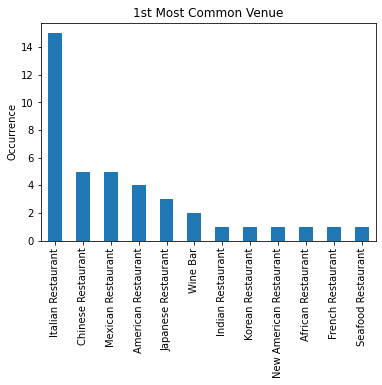

In [135]:
l1.plot(kind='bar')
plt.title('1st Most Common Venue')
plt.ylabel('Occurrence')

In [118]:
l2 = manhattan_merged['2nd Most Common Venue'].value_counts()

Visualize the occurrence of 2nd Most Common Venues

Text(0, 0.5, 'Occurrence')

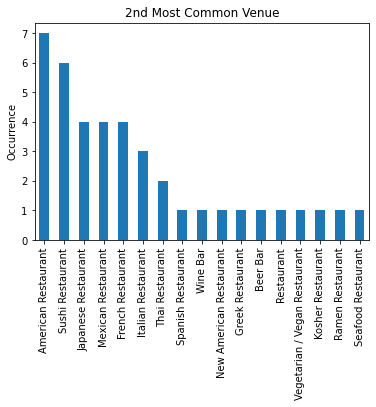

In [136]:
l2.plot(kind='bar')
plt.title('2nd Most Common Venue')
plt.ylabel('Occurrence')

In [119]:
l3 = manhattan_merged['3rd Most Common Venue'].value_counts()

Visualize the occurrence of 3rd Most Common Venues

Text(0, 0.5, 'Occurrence')

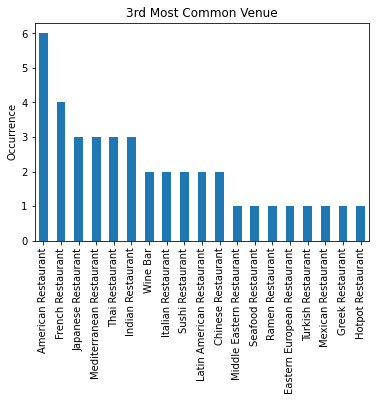

In [137]:
l3.plot(kind='bar')
plt.title('3rd Most Common Venue')
plt.ylabel('Occurrence')

In [120]:
l4 = manhattan_merged['4th Most Common Venue'].value_counts()

Visualize the occurrence of 4th Most Common Venues

Text(0, 0.5, 'Occurrence')

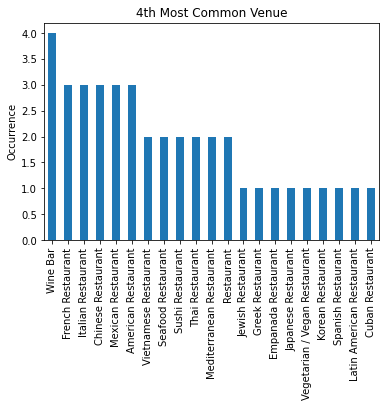

In [138]:
l4.plot(kind='bar')
plt.title('4th Most Common Venue')
plt.ylabel('Occurrence')

In [121]:
l5 = manhattan_merged['5th Most Common Venue'].value_counts()

Visualize the occurrence of 5th Most Common Venues

Text(0, 0.5, 'Occurrence')

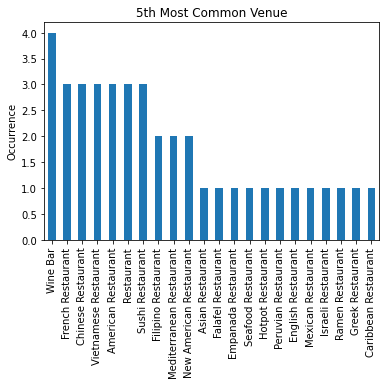

In [139]:
l5.plot(kind='bar')
plt.title('5th Most Common Venue')
plt.ylabel('Occurrence')

Find the dataframe index with Wine Bar as 1st most common Venue

In [115]:
id1 = manhattan_merged.index[manhattan_merged['1st Most Common Venue']=='Wine Bar']
id1

Int64Index([19, 37], dtype='int64')

In [116]:
# identify the neighborhood and cluster label associated
manhattan_merged[['Neighborhood', 'Cluster Labels']].iloc[id1]

,Neighborhood,Cluster Labels
19,East Village,3
37,Stuyvesant Town,3


The most probable areas around Manhattan to open a Wine Bar are East Village and Stuyvesant Town, both belonging to Cluster 3

## Conclusions

The aim of this project is to find the best neighborhood around Manhattan to open a new Wine Bar as investment.
We analysed the neighborhoods of Manhattan and we listed the venues in each area.
We clustered the area in 5, and we found the best area to open a Wine Bar based on similar features in that area.